**LSTM**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.metrics import mean_squared_error
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt

data = pd.read_csv('GOOGL_2006-01-01_to_2018-01-01.csv', parse_dates=['Date'])

data = data.drop("Name", axis=1)
data.set_index('Date', inplace=True)


# Ensure data has business day frequency
data = data.asfreq('b')

# Fill missing values
data = data.fillna(method='bfill').fillna(method='ffill')
data_vals = data.values


<ipython-input-36-15bbd2528493>:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='bfill').fillna(method='ffill')


**Create models and results**


In [ ]:
# Define the scheduler function
def step_decay(epoch):
    initial_lr = 0.01
    drop = 0.5
    epochs_drop = 10
    lr = initial_lr * (drop ** (epoch // epochs_drop))
    return lr

# Normalize the data (apply MinMaxScaler across all features)
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data_vals)

# Define sequence length and lag (the number of days to predict forward based on sequence length)
sequence_length = 100
lags = [1,5,10,20,30] # Prediction horizons. Use 1 value for one model creation and evaluation
y_tests = []
preds = []
rmses = []

for lag in lags:
  # Prepare input (X) and output (Y) sequences
  X, Y = [], []
  for i in range(len(data_normalized) - sequence_length-lag):
      X.append(data_normalized[i:i + sequence_length])  # Input: sequence_length x num_features
      Y.append(data_normalized[i + sequence_length + lag, 3])    # Output (Using close at index 3)

  X = np.array(X)
  Y = np.array(Y)


  # Split the data into training and testing sets
  split_ratio = 0.8
  split_index = int(split_ratio * len(X))
  X_train, X_test = X[:split_index], X[split_index:]
  Y_train, Y_test = Y[:split_index], Y[split_index:]

  # Create the callback
  lr_scheduler = LearningRateScheduler(step_decay)

  # Build the LSTM model for multivariate input and univariate output
  model = Sequential([
    LSTM(units=80, return_sequences=True, input_shape=(sequence_length, X.shape[2])),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])


  model.summary()
  plot_model(model, to_file="simple_lstm_model.png", show_shapes=True, show_layer_names=True)
  # Compile the model
  model.compile(optimizer='adam', loss='mean_squared_error')

  # Train the model
  model.fit(X_train, Y_train, epochs=50, batch_size=64, verbose=1, callbacks=[lr_scheduler])

  # Predict on the test set
  predictions = model.predict(X_test)

  # Inverse scale predictions and actual values for evaluation
  min_val = scaler.data_min_[3]  # Minimum value of feature 3
  max_val = scaler.data_max_[3]  # Maximum value of feature 3

  # Denormalize the predictions
  predictions_rescaled = predictions * (max_val - min_val) + min_val
  Y_test_rescaled = Y_test * (max_val - min_val) + min_val

  # Evaluate the model using Root Mean Squared Error (RMSE) for the fourth variable 'Close'
  rmse = np.sqrt(mean_squared_error(Y_test_rescaled, predictions_rescaled))
  print(f"Root Mean Squared Error: {rmse}")


  y_tests.append(Y_test_rescaled)
  preds.append(predictions_rescaled)
  rmses.append(rmse)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_31 (LSTM)                       │ (None, 100, 80)             │          27,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 100, 80)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_32 (LSTM)                       │ (None, 50)                  │          26,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,771 (210.04 KB)

 Trainable params: 53,771 (210.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0705 - learning_rate: 0.0100
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014 - learning_rate: 0.0100
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.4886e-04 - learning_rate: 0.0100
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.4901e-04 - learning_rate: 0.0100
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.2356e-04 - learning_rate: 0.0100
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.2070e-04 - learning_rate: 0.0100
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.3511e-04 - learning_rate: 0.0100
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.6850e-04 - learning_rate: 0.0100
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.1635e-04 - learning_rate: 0.0100
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.4571e-04 - learning_rate: 0.0100
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.7285e-04 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_33 (LSTM)                       │ (None, 100, 80)             │          27,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 100, 80)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_34 (LSTM)                       │ (None, 50)                  │          26,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,771 (210.04 KB)

 Trainable params: 53,771 (210.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1175 - learning_rate: 0.0100
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - learning_rate: 0.0100
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0010 - learning_rate: 0.0100
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0010 - learning_rate: 0.0100
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.4313e-04 - learning_rate: 0.0100
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8.0188e-04 - learning_rate: 0.0100
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.4678e-04 - learning_rate: 0.0100
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.7847e-04 - learning_rate: 0.0100
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.3575e-04 - learning_rate: 0.0100
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.0053e-04 - learning_rate: 0.0100
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.4816e-04 - learn

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_35 (LSTM)                       │ (None, 100, 80)             │          27,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 100, 80)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_36 (LSTM)                       │ (None, 50)                  │          26,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,771 (210.04 KB)

 Trainable params: 53,771 (210.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.1055 - learning_rate: 0.0100
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0017 - learning_rate: 0.0100
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012 - learning_rate: 0.0100
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012 - learning_rate: 0.0100
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.7247e-04 - learning_rate: 0.0100
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0010 - learning_rate: 0.0100
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.0091e-04 - learning_rate: 0.0100
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.3140e-04 - learning_rate: 0.0100
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.8761e-04 - learning_rate: 0.0100
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011 - learning_rate: 0.0100
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.2953e-04 - learning_rate

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_37 (LSTM)                       │ (None, 100, 80)             │          27,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 100, 80)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_38 (LSTM)                       │ (None, 50)                  │          26,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,771 (210.04 KB)

 Trainable params: 53,771 (210.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0370 - learning_rate: 0.0100
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - learning_rate: 0.0100
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014 - learning_rate: 0.0100
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013 - learning_rate: 0.0100
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0015 - learning_rate: 0.0100
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0013 - learning_rate: 0.0100
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - learning_rate: 0.0100
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012 - learning_rate: 0.0100
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011 - learning_rate: 0.0100
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011 - learning_rate: 0.0100
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011 - learning_rate: 0.0050
Epoch 12/50
3

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_39 (LSTM)                       │ (None, 100, 80)             │          27,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 100, 80)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_40 (LSTM)                       │ (None, 50)                  │          26,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,771 (210.04 KB)

 Trainable params: 53,771 (210.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0539 - learning_rate: 0.0100
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0021 - learning_rate: 0.0100
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - learning_rate: 0.0100
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0020 - learning_rate: 0.0100
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0018 - learning_rate: 0.0100
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0016 - learning_rate: 0.0100
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0015 - learning_rate: 0.0100
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0017 - learning_rate: 0.0100
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0016 - learning_rate: 0.0100
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0016 - learning_rate: 0.0100
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0016 - learning_rate: 0.0050
Epoch 12/5

**Plot predictions**

Predictions 1 days forward rmse: 36.213543098705244
Predictions 5 days forward rmse: 53.08719029695271
Predictions 10 days forward rmse: 60.903603606746735
Predictions 20 days forward rmse: 197.79344676684954
Predictions 30 days forward rmse: 188.49773423552256


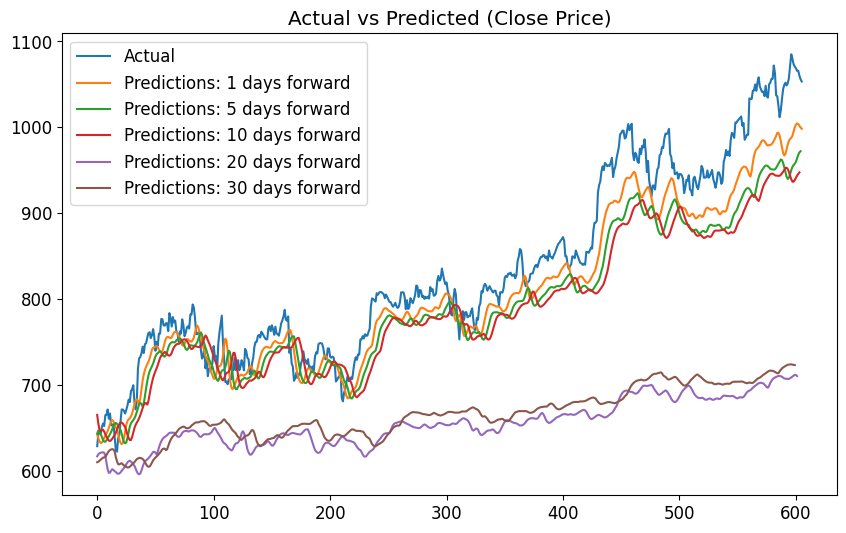

In [ ]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10, 6))
plt.plot(y_tests[0], label='Actual')

for i in range(len(preds)):
  plt.plot(preds[i], label='Predictions: '+ str(lags[i]) + ' days forward')
  print('Predictions ' + str(lags[i]) + ' days forward rmse: ' + str(rmses[i]))

plt.legend()
plt.title("Actual vs Predicted (Close Price)")
plt.savefig("LSTM_preds.png")
plt.show()
